Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

In [1]:
# core UW bit
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
from UWGeodynamics.scaling import units as u
from UWGeodynamics.scaling import dimensionalise
from UWGeodynamics.scaling import non_dimensionalise as nd

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
# 3rd party python modules
import math
import numpy as np
import os
import scipy

In [3]:
import geo_model_properties as modprop
import relrho_geo_material_properties as matprop

In [4]:
# shortcuts for parallel wrappers
barrier = GEO.uw.mpi.barrier
rank    = GEO.rank

In [5]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
barrier()

In [6]:
# Scaling
exec(open('geo_moresi_2014_scaling.py').read())
scaling_coefficients

[mass],1.25e+37 kilogram
[length],1000000.0 meter
[temperature],1299.85 kelvin
[time],125000000000.0 second
[substance],1.0 mole


In [7]:
GEO.scaling.get_coefficients()

[mass],1.25e+37 kilogram
[length],1000000.0 meter
[temperature],1299.85 kelvin
[time],125000000000.0 second
[substance],1.0 mole


In [8]:
dimensionalise(10.,u.meters)

10000000.0 <Unit('meter')>

In [9]:
non_dimensionalise(100.*u.megapascal)

0.125

In [10]:
# double check scaling
if rank == 0:
    print("Value of 0.1 as a stress = ",
          dimensionalise(0.1,u.megapascal))
    
    
    print("Dimensionless Value of 100*u.megapascal is = ", 
          nd(100.*u.megapascal))


Value of 0.1 as a stress =  79.99999999999999 megapascal
Dimensionless Value of 100*u.megapascal is =  0.125


**Setup parameters**


In [11]:
# xRes = 256
# yRes =  96 
# zRes =  96

xRes = 22
yRes = 22
zRes = 22

dim = 3

checkpoint_restart = False
if checkpoint_restart == True:
    # you need to define these
    outputPath_restart = os.path.join(os.path.abspath("."),"output_checkPoint_restart/")
    time = 4.38067181e+03
    step = 1

In [12]:
# # Domain
# boxLength = nd(modprop.boxLength)
# boxHeight = nd(modprop.boxHeight)
# boxWidth  = nd(modprop.boxWidth)

**Create mesh and finite element variables**

In [13]:
# if dim==2:
#     elementRes  = (xRes, yRes)
#     minCoord    = (0., -nd(boxHeight)) 
#     maxCoord    = (nd(boxLength), 0.)
# else:
#     elementRes  = (xRes, yRes, zRes)
#     minCoord    = (0., -nd(boxHeight), 0.) 
#     maxCoord    = (nd(boxLength), 0., nd(boxWidth))

# mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
#                                  elementRes  = elementRes, 
#                                  minCoord    = minCoord,
#                                  maxCoord    = maxCoord,
#                                ) 

In [14]:
# Domain
boxLength = modprop.boxLength
boxHeight = modprop.boxHeight
boxWidth  = modprop.boxWidth

In [15]:
# Define our vertical unit vector using a python tuple
if dim == 2:
    elementRes = (xRes, yRes)
    minCoord   = (0., -boxHeight)
    maxCoord   = (boxLength, 0.)
    z_hat = ( 0.0, 1.0)
    
else:
    elementRes = (xRes, yRes, zRes)
    minCoord   = (0., -boxHeight, 0.)
    maxCoord   = (boxLength, 0., boxWidth)
    z_hat = ( 0.0, 1.0, 0.0 )
    
Model = GEO.Model(elementRes = elementRes,
                  minCoord   = minCoord,
                  maxCoord   = maxCoord,
                  gravity    = z_hat )

### Questions: _postSoftening_

This looks like a 'hasYielded' swarm variable. It is a bool, initially set to 0 and set to 1 iff the particle has yielded at any stage. Once triggered a 1 can't heal back to 0. It enables a bifurication of the cohesion value used in the vonMises yield criterion.

I could add a swarm variable for _postSoftening_ variable in the original model of Bec's
`Model.add_swarm_variable`

or is the `_ViscosityFunction._isYielding` from `UWGeo`

**checkpoint_restart**

In [16]:
# # if reloading from checkpoint
if checkpoint_restart == True:
    swarm.load(         outputPath_restart+'swarm.'         + str(step).zfill(5) +'.h5')
    materialIndex.load( outputPath_restart+'materialIndex.' + str(step).zfill(5) +'.h5')
    postSoftening.load( outputPath_restart+'postSoftening.' + str(step).zfill(5) +'.h5')
else:
#     swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=particlesPerCell )
#     swarm.populate_using_layout( layout=swarmLayout )
#     postSoftening.data[:] = 0 # initial softening flag to False
    exec(open('geo_moresi_2014_material_layout.py').read())
    exec(open('relrho_geo_material_properties.py').read())
#     if dim == 2:
#         materialIndex.data[:] = fn.branching.conditional( conditions_2d ).evaluate(Model.swarm)
#     else:
#         materialIndex.data[:] = fn.branching.conditional( conditions_3d ).evaluate(swarm)
    

In [17]:
# search through layout file and link geometries to materials
# ie conditions_3d -> material_list
### CAN 
# 
below_150km = Model.y < nd(-150.*u.kilometers)

for i in reversed(conditions_3d):  # IMPORTANT 'reversed'
    index = i[1]                   # find material index
    for x in material_list:        # if index in material_list
        if x["index"] == index:    # create material with Polygon() shape
            print("Creating", x["name"])
            m = Model.add_material(name=x["name"], shape=i[0])
            
            m.density   = x["density"]
            m.viscosity = x["viscosity"]
            
            c0 = x["cohesion"]
            c2 = x["cohesion2"] if x.get('cohesion2') else None
            m.plasticity = GEO.VonMises(cohesion = c0,
                                        cohesionAfterSoftening = c2)


Creating upper mantle
Creating craton2
Creating craton1
Creating trans2
Creating trans1
Creating backArc2
Creating backArc1
Creating oceanic plate 4
Creating oceanic plate 3
Creating oceanic plate 2
Creating oceanic plate 1
Creating buoyStrip
Creating lower mantle


**Eclogite transition**

Assume that the oceanic crust transforms instantaneously and completely to eclogite at a depth of 150 km

In [18]:
# We predefine the phase change material by hand
# because it does't exist initially.
# The phase change is between 
# 'oceanic plate 1' -> 'oceanic plate 1 after phase change'
# see file geo_material_properties.py

# Get the phase change by hand
m = material_list[3]
# register new material
op_change = Model.add_material(name=m["name"])
op_change.density   = m["density"]
op_change.viscosity = m["viscosity"]
c0 = m["cohesion"]
c2 = m["cohesion2"] if m.get('cohesion2') else None
op_change.plasticity = GEO.VonMises(cohesion = c0,
                            cohesionAfterSoftening = c2)

# now assign a `PhaseChange` to the newly registered material
for m in Model.materials:
    if m.name == "oceanic plate 1":
        m.phase_changes = GEO.PhaseChange( (Model.y < nd(-150.*u.kilometers)),
                                          op_change.index)
        break


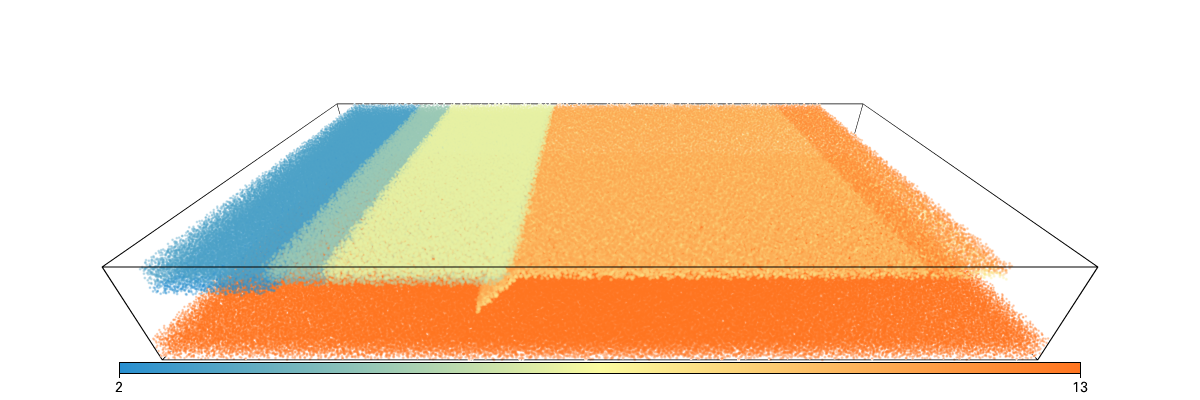

In [19]:
figsize=(1000,300)
camera = ['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 1


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
Fig.script(camera)

# Render in notebook
Fig.show()

In [20]:
# build 3D surface tracers, ie y=0. NOT available for 2D
def tracer_coords(name, minX, maxX, minZ, maxZ):
    
    xx = np.linspace(minX, maxX, max(1, int(maxX-minX))*100)
    yy = np.zeros(1)
    zz = np.linspace(minZ, maxZ, max(1, int(maxX-minX))*100)

    xx, yy, zz = np.meshgrid(xx,yy,zz)
        
    tracers = Model.add_passive_tracers(name,
                                        vertices  = [0.,0.,0.],
                                        centroids = [xx, yy, zz]) 

In [21]:
# Over-riding plate particles
tracer_coords("orp", nd(backarc_xStart),nd(slab_xStart),
              0., nd(boxWidth))
tracer_coords("slab",nd(slab_xStart),nd(bouyStrip_xStart),
              0., nd(slab_dz))
tracer_coords("cont", nd(craton_xStart), nd(backarc_xStart),
              0., nd(boxWidth))
tracer_coords("arc", nd(ribbon_xStart), nd(ribbon_xStart+ribbon_dx),
              nd(ribbon_dz), nd(boxWidth))
tracer_coords("buoy", nd(bouyStrip_xStart), nd(slab_xStart+slab_dx),
              0., nd(slab_dz))

In [22]:
on_grid_x = fn.math.sin(10.*np.pi*Model.x) > 0.9
on_grid_y = fn.math.sin(10.*np.pi*Model.z) > 0.9

grid_conditions = [  
                    ( on_grid_x, 1.),
                    ( on_grid_y, 1.),
                    ( True, -1.),
                  ]

for t in Model.passive_tracers.items():
    new_var = t[1].add_variable(dataType="float", count=1)
    new_var.data[:] = fn.branching.conditional(grid_conditions).evaluate(t[1])

In [23]:
Model.passive_tracers.keys()

odict_keys(['orp', 'slab', 'cont', 'arc', 'buoy'])


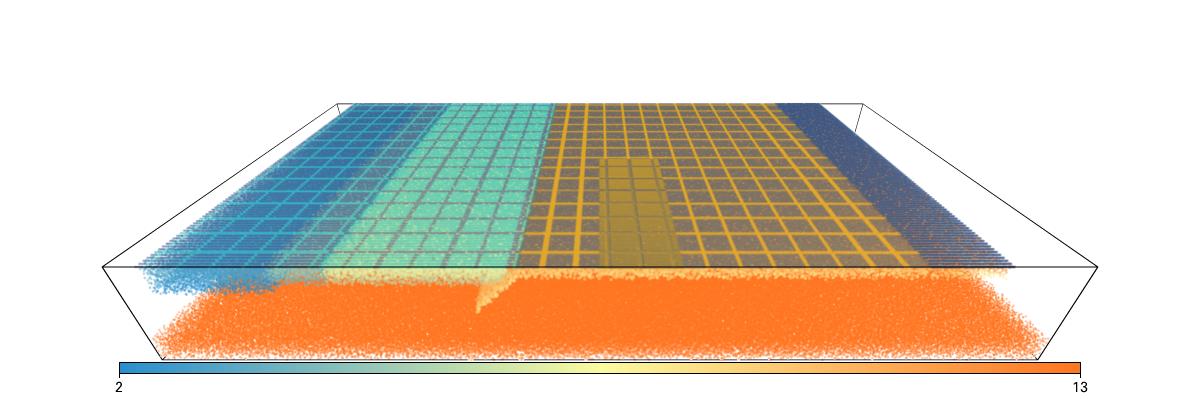

In [24]:
FigTracers = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
FigTracers.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

def get_show_tracer(name, colours):
    t = Model.passive_tracers.get(name)
    if not t: raise RuntimeError("ERROR: fine tracer called ", name)
    
    FigTracers.Points(t, t.variables[-1],fn_size=2.,
                      colours=colours,opacity=0.5,colourBar=False)
    
if dim == 3:
    
    get_show_tracer(name='orp', colours="#22BBBB #335588")
    get_show_tracer(name='slab', colours="Gray40 Goldenrod")
    get_show_tracer(name='cont', colours="#335588 #22BBBB")
    get_show_tracer(name='arc', colours="Goldenrod Grey41")
    get_show_tracer(name='buoy', colours="#335588 #335588")

# Rotate camera angle
FigTracers.script(camera)

# Render in notebook
FigTracers.show()

In [25]:
Model.minViscosity = dimensionalise(1., u.Pa * u.sec)
Model.maxViscosity = dimensionalise(1e5, u.Pa * u.sec)

In [26]:
Model.set_velocityBCs( left=[0.,None,None], right=[0.,None,None],
                       bottom=[None,0.,None], top=[None,0.,None],
                       front=[None,None,0.], back=[None,None,0.])

In [27]:
Model.init_model()

In [ ]:
# figViscosity = vis.Figure(figsize=figsize, axis=True)
# figViscosity.append( vis.objects.Points(swarm, viscosityFn, colours='dem1', fn_size=2., logScale=True) )
# if dim == 3:
#     figViscosity.script(camera)
# figViscosity.show()

In [ ]:
Fig = vis.Figure(figsize=(1200,400))

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.densityField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Rotate camera angle
Fig.script(camera)

# Render in notebook
# Fig.show()

In [28]:
if rank == 0:
    with open(outputPath+'FrequentOutput.dat','a') as f:
         f.write('step\t time(Myr)\t Vrms(cm/yr)\n')
            
def post_solve_hook():
    vrms = Model.stokes_SLE.velocity_rms()
    step = Model.step
    time = Model.time.to(u.megayear)
    
    if rank == 0:
        with open(outputPath+'FrequentOutput.dat','a') as f:
             f.write(f"{step}\t{time:5e}\t{vrms:5e}")
        
Model.post_solve_functions["Measurements"] = post_solve_hook

In [ ]:
## We can test different solvers by uncommentting this section
# solver = Model.solver
# # System level solver options
# solver.options.main.Q22_pc_type = "uwscale"
# solver.options.main.ksp_k2_type = "GMG"
# solver.options.main.ksp_type    = "bsscr"
# solver.options.main.pc_type     = "none"
# solver.options.main.penalty     = 50.
# #solver.options.main.list()

# # Schur complement solver options
# solver.options.scr.ksp_rtol = 1.0e-3 
# solver.options.scr.ksp_type = "fgmres"
# #solver.options.main.list()

# # Inner solve (velocity), A11 options
# solver.options.A11.ksp_rtol = 1.0e-4
# solver.options.A11.ksp_type = "fgmres"
# #solver.options.A11.list()
# solver.print_petsc_options()

In [ ]:
Model.run_for(nstep=1, checkpoint_interval=1)

Running with UWGeodynamics version 2.9.0
